In [2]:
# Importing necessary libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_percentage_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

## Data preprocessing

###Read data

In [3]:
# Load data
df = pd.read_csv('/BA_trainmodel/data/INTC.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,45.959999,47.470001,45.770000,47.080002,41.343937,18774600
1,2019-01-03,46.150002,46.279999,44.389999,44.490002,39.069477,32267300
2,2019-01-04,45.840000,47.570000,45.540001,47.220001,41.466869,35447300
3,2019-01-07,47.099998,48.000000,46.750000,47.439999,41.660065,22736800
4,2019-01-08,47.799999,48.029999,46.779999,47.740002,41.923512,22749200
...,...,...,...,...,...,...,...
1114,2023-06-06,29.770000,31.450001,29.700001,30.959999,30.959999,42295300
1115,2023-06-07,31.030001,31.370001,30.930000,31.280001,31.280001,39098000
1116,2023-06-08,31.430000,31.850000,31.059999,31.820000,31.820000,35199000
1117,2023-06-09,31.930000,31.990000,30.680000,31.340000,31.340000,40218000


###Reset index

In [4]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)

In [5]:
# Select the Close column as the dependent variable
df_Close = df[['Close']]
#df_Close = df_Close.dropna() # Drop missing values
df_Close = df_Close.reset_index(drop=True) # Reset the index
df_Close.head(20)

,Close
0,47.080002
1,44.490002
2,47.220001
3,47.439999
4,47.740002
5,48.009998
6,48.560001
7,48.930000
8,48.349998
9,48.599998


###Data normalization

In [6]:
# Scaling the data
scaler=MinMaxScaler(feature_range=(0,1))
data_scaled=scaler.fit_transform(df_Close)
data_scaled

array([[0.50906591],
       [0.44962133],
       [0.5122791 ],
       ...,
       [0.15882488],
       [0.14780812],
       [0.18751434]])

###Data splitting

In [7]:
# Split the data into training, validation and test dataset in a ratio of 6:2:2
train_size = int(0.6 * len(data_scaled))
val_size = int(0.2 * len(data_scaled))
test_size = len(data_scaled) - train_size - val_size

train_data = data_scaled[: train_size]
val_data = data_scaled[train_size : train_size + val_size]
test_data = data_scaled[train_size + val_size :]

In [8]:
def create_dataset(dataset, time_step, prev_data=None):
    dataX, dataY = [], []
    start_index = 0
    
    # If previous data is available
    if prev_data is not None:
        start_index = max(0, time_step - len(prev_data))
        dataset = np.concatenate((prev_data, dataset))
        
    for i in range(start_index, len(dataset)-time_step):
        dataX.append(dataset[i:(i+time_step), 0])
        dataY.append(dataset[i + time_step, 0])
        
    return np.array(dataX), np.array(dataY)


##Model training and testing

###Define the parameter GBT

In [9]:
# Grid of time_steps to try
time_step_grid = [30, 50, 60, 70, 100]

In [10]:
# Define the parameter grid
param_grid = {
    'n_estimators': [200, 300, 500],
    'learning_rate': [0.05, 0.1, 0.15],
    'max_depth': [1, 2, 3],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3, 4]
}


In [11]:
# Defining the GBT Model
gbt = GradientBoostingRegressor(n_iter_no_change=5, tol=0.02, random_state=0)

In [12]:
random_search = RandomizedSearchCV(estimator=gbt, param_distributions=param_grid, n_iter=100, cv=10, verbose=2, random_state=0, n_jobs=-1)

In [13]:
best_val_RMSE = float("inf")
best_params = None
best_time_step = None
best_gbt = None
best_y_pred_val_inv = None
best_y_val_inv = None

In [14]:
for time_step in time_step_grid:
    # Reshape into X=t,t+1,t+2..t+time_step_grid[i] and Y=t+time_step_grid[i]
    X_train, y_train = create_dataset(train_data, time_step)

    # Prepare previous data for validation set
    last_train_data = train_data[-time_step:]

    # Create validation set
    X_val, y_val = create_dataset(val_data, time_step, last_train_data)

    # Fitting the random search model
    random_search.fit(X_train, y_train)

    # Create a new model with these parameters
    candidate_gbt = GradientBoostingRegressor(**random_search.best_params_, random_state=0)

    # Fit the model with the training data
    candidate_gbt.fit(X_train, y_train)

    # Predicting on validation data
    y_pred_val = candidate_gbt.predict(X_val)
    y_pred_val_inv = scaler.inverse_transform(y_pred_val.reshape(-1,1))
    y_val_inv = scaler.inverse_transform(y_val.reshape(-1,1))

    valid_RMSE =  mean_squared_error(y_val_inv, y_pred_val_inv, squared=False)
    # Check if this model is better than the previous ones
    if valid_RMSE < best_val_RMSE:
        best_params = random_search.best_params_
        best_val_RMSE = valid_RMSE
        best_time_step = time_step
        best_gbt = candidate_gbt
        best_y_pred_val_inv = y_pred_val_inv
        best_y_val_inv = y_val_inv

    # Print the RMSE for this time_step
    print(f"Time step: {time_step}, Validation RMSE: {valid_RMSE}")

print("Best time step: ", best_time_step)
print("Best parameters: ", best_params)
print("Validation RMSE with best time step and parameters: ", best_val_RMSE)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


Time step: 30, Validation RMSE: 2.5813109271758736
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Time step: 50, Validation RMSE: 3.022928821749663
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Time step: 60, Validation RMSE: 3.0203274648590286
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Time step: 70, Validation RMSE: 2.7136099583057045
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Time step: 100, Validation RMSE: 2.765300878515868
Best time step:  30
Best parameters:  {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 3, 'learning_rate': 0.15}
Validation RMSE with best time step and parameters:  2.5813109271758736


##Train with best time step and best parameters

In [15]:
# Once we have the best params and time step, we recreate all datasets and fit the model again
X_train, y_train = create_dataset(train_data, best_time_step)
X_val, y_val = create_dataset(val_data, best_time_step)


# Prepare previous data for test set
last_points_train = val_data[-best_time_step:]
X_test, y_test = create_dataset(test_data, best_time_step, last_points_train)

In [16]:
X_test

array([[0.42758776, 0.37479917, 0.3467982 , ..., 0.31696118, 0.3516181 ,
        0.35942164],
       [0.37479917, 0.3467982 , 0.32774844, ..., 0.3516181 , 0.35942164,
        0.36056921],
       [0.3467982 , 0.32774844, 0.29538673, ..., 0.35942164, 0.36056921,
        0.3282075 ],
       ...,
       [0.095249  , 0.11383982, 0.14138166, ..., 0.11383982, 0.1390865 ,
        0.14643105],
       [0.11383982, 0.14138166, 0.12393846, ..., 0.1390865 , 0.14643105,
        0.15882488],
       [0.14138166, 0.12393846, 0.11177415, ..., 0.14643105, 0.15882488,
        0.14780812]])

In [17]:
# Create a new model with the best parameters
best_gbt = GradientBoostingRegressor(**best_params, random_state=0)

In [18]:
# Create a new model with the best parameters
best_gbt.fit(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)))

GradientBoostingRegressor(learning_rate=0.15, min_samples_leaf=4,
                          n_estimators=500, random_state=0)

In [19]:
# Now use this to make predictions
y_pred_test=best_gbt.predict(X_test)

##Testing process

In [20]:
# And scale the predictions back to the original range
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))
y_pred_test_inv = scaler.inverse_transform(y_pred_test.reshape(-1,1))


In [21]:
test_MAPE = mean_absolute_percentage_error(y_test_inv, y_pred_test_inv)
test_RMSE = mean_squared_error(y_test_inv, y_pred_test_inv, squared=False)
test_MSLE = mean_squared_log_error(y_test_inv, y_pred_test_inv)
print('MAPE on the data test:', test_MAPE)
print('RMSE on the data test', test_RMSE)
print('MSLE on the data test', test_MSLE)

MAPE on the data test: 0.31170061144422756
RMSE on the data test 9.40742223752905
MSLE on the data test 0.07620927053274322


##Predicting the next 30 days

In [22]:
# Predict the closing prices for the next 30 days
x_input=test_data[-best_time_step:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=best_time_step
i=0
while(i<30):
    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        next_date = best_gbt.predict(x_input)
        print("{} day output {}".format(i,next_date))
        temp_input.extend(next_date.tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(next_date.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps))
        next_date = best_gbt.predict(x_input)
        print(next_date[0])
        temp_input.extend(next_date.tolist())
        print(len(temp_input))
        lst_output.extend(next_date.tolist())
        i=i+1


0.3156770552311646
31
1 day input [0.11177415 0.13197154 0.14551296 0.13977507 0.13472573 0.11934817
 0.11636445 0.09088825 0.09295389 0.11246268 0.09915077 0.09111776
 0.10970851 0.11544641 0.12347948 0.10580675 0.09410144 0.05737893
 0.09410144 0.1168235  0.1501033  0.14298827 0.14711955 0.11383982
 0.1390865  0.14643105 0.15882488 0.14780812 0.18751434 0.31567706]
1 day output [0.32214114]
2 day input [0.13197154 0.14551296 0.13977507 0.13472573 0.11934817 0.11636445
 0.09088825 0.09295389 0.11246268 0.09915077 0.09111776 0.10970851
 0.11544641 0.12347948 0.10580675 0.09410144 0.05737893 0.09410144
 0.1168235  0.1501033  0.14298827 0.14711955 0.11383982 0.1390865
 0.14643105 0.15882488 0.14780812 0.18751434 0.31567706 0.32214114]
2 day output [0.33573342]
3 day input [0.14551296 0.13977507 0.13472573 0.11934817 0.11636445 0.09088825
 0.09295389 0.11246268 0.09915077 0.09111776 0.10970851 0.11544641
 0.12347948 0.10580675 0.09410144 0.05737893 0.09410144 0.1168235
 0.1501033  0.14298

In [23]:
lst_output = scaler.inverse_transform(np.array(lst_output).reshape(-1,1))
print('Predicted closing prices for the next 30 days:')
print(lst_output)

Predicted closing prices for the next 30 days:
[[38.65404961]
 [38.93568972]
 [39.5279053 ]
 [39.54682233]
 [39.54682233]
 [39.37486988]
 [39.37486988]
 [39.64460262]
 [39.69340945]
 [39.69340945]
 [39.69340945]
 [39.68669027]
 [39.68669027]
 [39.49367438]
 [39.50864613]
 [39.50864613]
 [39.50864613]
 [39.50864613]
 [39.37029205]
 [39.00039547]
 [39.00039547]
 [38.84307403]
 [38.84307403]
 [38.64882283]
 [38.03751042]
 [37.80100934]
 [37.80100934]
 [37.80118914]
 [37.80118914]
 [37.80765726]]


##Preparing the forecast date index

##Visualization

In [24]:
# Convert integer indexes back to datetime
train_data_index = df.index[:train_size]
val_data_index = df.index[train_size:train_size+ val_size]
test_data_index = df.index[train_size + val_size:]

# Assuming predict_data_index is the 30 days following the last date in the validation data
predict_data_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=30)

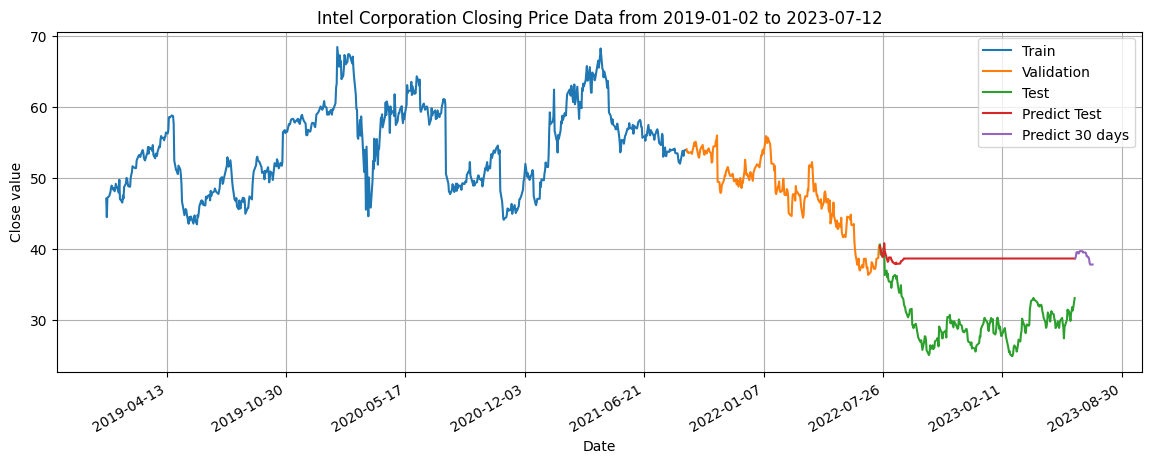

In [25]:
# Plotting Data
plt.figure(figsize=(14, 5))
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')
plt.plot(val_data_index, scaler.inverse_transform(val_data), label='Validation')
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')
plt.plot(test_data_index, y_pred_test_inv, label='Predict Test')
plt.plot(predict_data_index, lst_output, label='Predict 30 days')

plt.grid()
plt.title(f"Intel Corporation Closing Price Data from {train_data_index[0].strftime('%Y-%m-%d')} to {predict_data_index[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=200)) # Select markers spaced 200 days apart
plt.gcf().autofmt_xdate() #  Rotate date labels for better readability
plt.tight_layout
plt.legend()
plt.savefig('../Image/GBT_622_INTC.png')

plt.show()